# **Deep Learning and CNN for Computer Vision, Hokkaido University**

## Day 1, Notebook -3: Logistic Regression using Neural Network


In this session you will be implementing a Logistic Regression Classifier for Dogs and Cats classification.

So lets get started!


## Tasks for this Notebook:

1. Implementation of Logistic Regression classifier using Keras API.
2. Train and test model
3. Using Callbacks


### Step 1: Import required packages

we will need tensorflow, numpy, os and keras


In [71]:
## Import the required packages ##
import tensorflow as tf
import os

import math, numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt

import os
import h5py
import glob
import cv2

from tensorflow.keras.preprocessing import image

In [72]:
from tensorflow import keras
print(tf.__version__)


2.17.1


### Step 2: Dataset Preparation, Dogs and Cats

In [73]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [74]:
# Unzip the Dogs and Cats zip file

%cd "/content/gdrive/MyDrive/Hokkaido Uni DL/Day-1"
!unzip Cats-Dogs-dataset-64.zip

/content/gdrive/MyDrive/Hokkaido Uni DL/Day-1
Archive:  Cats-Dogs-dataset-64.zip
replace TestData/cat/cat.282.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [75]:
!ls

Cats-Dogs-dataset-64.zip	Day1-NB2-EdgeDetectionUsingConvolution.ipynb	       TestData
dataset				Day1-NB2-EdgeDetectionUsingConvolution-Solution.ipynb  test_x.h5
dataset.zip			Day1-NB3-LogisticRegression-using-NN.ipynb	       TrainData
Day1-NB1-Intro_to_OpenCV.ipynb	model_1.png					       train_x.h5


### Helper function to read the Cats and Dogs dataset and return the train and test splits (Don't modify)

In [76]:
def loadDataset():

  ## Read all the train and test images and flatten them for training and testing
  train_path   = "./TrainData"
  test_path    = "./TestData"
  train_labels = os.listdir(train_path)
  test_labels  = os.listdir(test_path)

  image_size       = (64, 64)
  num_train_images = 200
  num_test_images  = 100
  num_channels     = 3

  train_x = np.zeros(((image_size[0]*image_size[1]*num_channels), num_train_images))
  train_y = np.zeros((1, num_train_images))
  test_x  = np.zeros(((image_size[0]*image_size[1]*num_channels), num_test_images))
  test_y  = np.zeros((1, num_test_images))

  #----------------
  # TRAIN dataset
  #----------------
  count = 0
  num_label = 0
  for i, label in enumerate(train_labels):
    cur_path = train_path + "/" + label
    #print(glob.glob(cur_path + "/*.jpg"))
    for image_path in glob.glob(cur_path + "/*.jpg"):
      img = image.load_img(image_path, target_size=image_size)
      #print(image_path)
      x   = image.img_to_array(img)
      x   = x.flatten()
      x   = np.expand_dims(x, axis=0)
      train_x[:,count] = x
      train_y[:,count] = num_label
      count += 1
      #Read only 100 samples for each class for training
      if (count==99 or count==199):
        break
    num_label += 1

  #--------------
  # TEST dataset
  #--------------
  count = 0
  num_label = 0
  for i, label in enumerate(test_labels):
    cur_path = test_path + "/" + label
    for image_path in glob.glob(cur_path + "/*.jpg"):
      img = image.load_img(image_path, target_size=image_size)
      x   = image.img_to_array(img)
      x   = x.flatten()
      x   = np.expand_dims(x, axis=0)
      test_x[:,count] = x
      test_y[:,count] = num_label
      count += 1
    num_label += 1

  #------------------
  # standardization
  #------------------
  train_x = train_x/255.
  test_x  = test_x/255.


  ## Print the statistics of the data
  print ("train_labels : " + str(train_labels))
  print ("train_x shape: " + str(train_x.shape))
  print ("train_y shape: " + str(train_y.shape))
  print ("test_x shape : " + str(test_x.shape))
  print ("test_y shape : " + str(test_y.shape))

  #-----------------
  # save using h5py
  #-----------------
  h5_train = h5py.File("train_x.h5", 'w')
  h5_train.create_dataset("data_train", data=np.array(train_x))
  h5_train.close()

  h5_test = h5py.File("test_x.h5", 'w')
  h5_test.create_dataset("data_test", data=np.array(test_x))
  h5_test.close()

  return train_x, train_y, test_x, test_y


In [77]:
## Read the Cats and Dogs dataset
train_set_x, train_set_y, test_set_x, test_set_y = loadDataset()

train_labels : ['cat', 'dog']
train_x shape: (12288, 200)
train_y shape: (1, 200)
test_x shape : (12288, 100)
test_y shape : (1, 100)


In [78]:
# Check whats inside the 'Y' matrix/array
test_set_y

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]])

### Step 3:  Design the Logistic Regression classifier

In [79]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(64, 64, 3)),
    keras.layers.Dense(1, activation='sigmoid')
])

## **Notes:**
* **Sequential model.** This is the simplest kind of Keras model, for neural networks which defines a SEQUENCE of layers.

* **Flatten.** Flatten just takes that image and turns it into a 1-dimensional vector.

* Next we add a Dense hidden layer with 1 neuron, also using the **Sigmoid** activation function.  
* **Dense.** Adds a layer to the neural network which is followed by activation function of Sigmoid.


## Step 4: Compile the model: add loss function, optimizer etc.

In [80]:
# Compile the model: Add loss function, Optimizer, and evaluation metrics
model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.01), # Adjust learning rate as needed
              loss='binary_crossentropy', # Binary cross-entropy is negative log-likelihood for binary classification
              metrics=['accuracy'])


## **Notes:**
This code snippet configures the training process for a logistic regression model implemented using TensorFlow/Keras. Let's break down each part:

**`model.compile(...)`**

This line compiles the Keras model, preparing it for training.  Here's a breakdown of the arguments:

* **`optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)`**: This specifies the optimization algorithm used to update the model's weights during training.  Here, Stochastic Gradient Descent (SGD) is chosen with a learning rate of 0.01.

    * **Optimizer:** The optimization algorithm is crucial for finding the best model weights.  SGD iteratively adjusts weights to minimize the loss function.  Other optimizers like Adam or RMSprop are often preferred over SGD in practice, as they tend to converge faster and more reliably.
    * **Learning Rate (0.01):** This controls the step size during weight updates.  A smaller learning rate leads to slower but potentially more stable convergence, while a larger learning rate can lead to faster convergence but may overshoot the optimal weights or fail to converge.  The optimal learning rate is problem-dependent and often needs tuning.


* **`loss='binary_crossentropy'`**: This sets the loss function, which measures the difference between the model's predictions and the true labels.  'binary_crossentropy' is appropriate for binary classification problems (two classes, in this case, cats and dogs).  It calculates the negative log-likelihood of the predicted probabilities given the true labels.  This loss function penalizes the model more for incorrect predictions with high confidence.  For multi-class classification, other loss functions like 'categorical_crossentropy' would be used.

* **`metrics=['accuracy']`**: This defines the metrics used to evaluate the model's performance during training and testing. Here, accuracy (the percentage of correctly classified samples) is used.  You could include other metrics like precision, recall, or F1-score for a more comprehensive evaluation.

**In summary:** This `model.compile()` line sets up the model for training by defining how the model's weights will be adjusted (SGD with a learning rate of 0.01), how the model's performance will be measured (binary cross-entropy loss), and what metrics will be tracked during training (accuracy in this case).  These settings are crucial for effective training and depend on the nature of the problem and the dataset.


## Step 5: Train the model

In [81]:
# Train the model
H = model.fit(train_set_x.T.reshape(-1, 64, 64, 3), train_set_y.T, epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4835 - loss: 2.1566
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5171 - loss: 2.5282  
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4294 - loss: 3.3815 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5299 - loss: 2.0075 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5092 - loss: 2.4324 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5443 - loss: 2.3681 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4983 - loss: 2.2590 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4733 - loss: 2.9346 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4578 - loss: 3.5872 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4455 - loss: 2.9485 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5140 - loss: 2.3898 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5317 - lo

## Step 6: Evaluate the model on test dataset and test on single image

In [82]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_set_x.T.reshape(-1, 64, 64, 3), test_set_y.T, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Test a single image
def predict_single_image(image_path):
  img = image.load_img(image_path, target_size=(64, 64))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0  # Normalize the image
  prediction = model.predict(x)
  predicted_class = 1 if prediction[0][0] > 0.5 else 0
  print(f"Prediction: {predicted_class}")
  return predicted_class

# Example usage
image_path = "/content/gdrive/MyDrive/Hokkaido Uni DL/Day-1/TestData/cat/cat.282.jpg" # Replace with actual path to your test image
predicted_class = predict_single_image(image_path)

Test Loss: 3.1773
Test Accuracy: 0.5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Prediction: 0


## Visualize the model and Model Summary

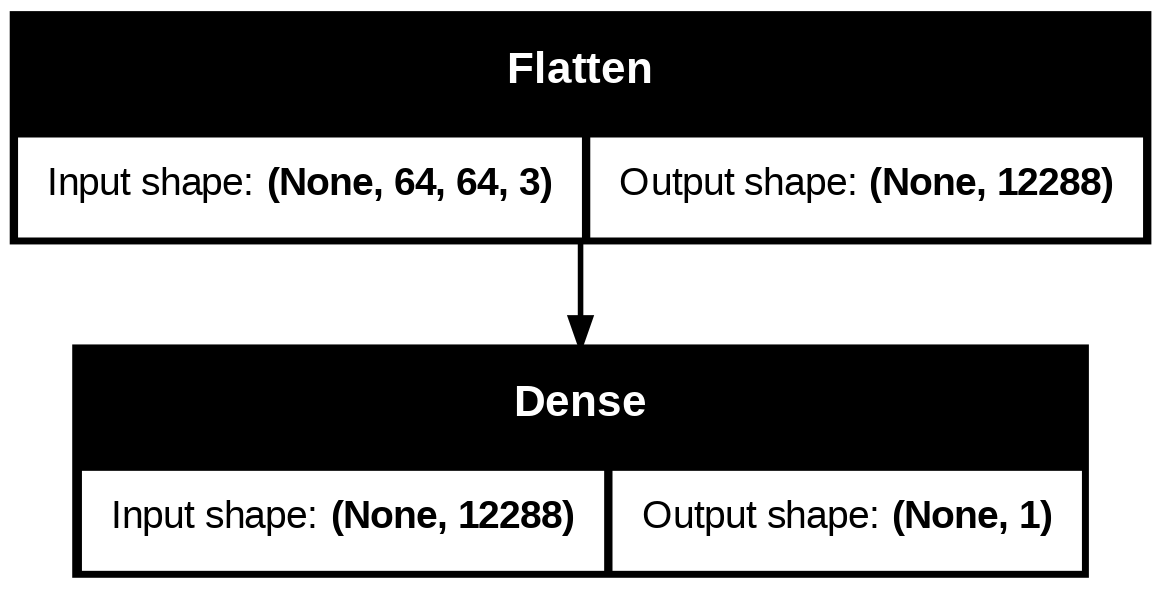

In [83]:
#Visualize Network Model
modelViz_file= 'model_1.png' # Model filename

# Plot model
keras.utils.plot_model(model, to_file=modelViz_file, show_shapes=True)

In [84]:
# Model Summary
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)                 │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │          12,289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,291 (48.02 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Plot the loss curve

In [85]:
type(H)
print(H.history.keys())

dict_keys(['accuracy', 'loss'])


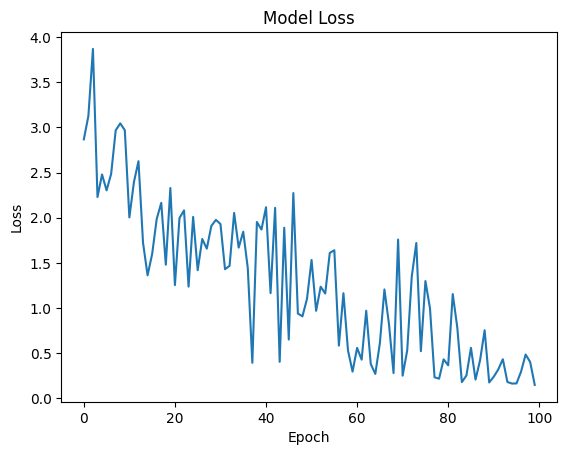

In [86]:
# Plot the loss curve
plt.plot(H.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Using Callbacks for early stopping training

In [87]:
# Define Callback and stopping criteria
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.1): #Stopping criteria
      print("\nReached required accuracy so cancelling training!")
      self.model.stop_training = True

In [88]:
# Design the model
callbacks = myCallback()
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(64, 64, 3)),
    keras.layers.Dense(1, activation='sigmoid')
])


In [89]:
# Compile the model: add loss function, optimizer etc.
model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.01), # Adjust learning rate as needed
              loss='binary_crossentropy', # Binary cross-entropy is negative log-likelihood for binary classification
              metrics=['accuracy'])

In [90]:
# Train the model with Callback
H = model.fit(train_set_x.T.reshape(-1, 64, 64, 3), train_set_y.T, epochs=1000, callbacks=[callbacks])

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5050 - loss: 2.4859
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4847 - loss: 2.7488 
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5235 - loss: 3.5640 
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5583 - loss: 2.4890 
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6008 - loss: 2.2255 
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5058 - loss: 3.7235 
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5606 - loss: 2.4239 
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5104 - loss: 2.1795 
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5269 - loss: 1.9358 
Epoch 10/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5559 - loss: 1.7235 
Epoch 11/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5586 - loss: 2.1142 
Epoch 12/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

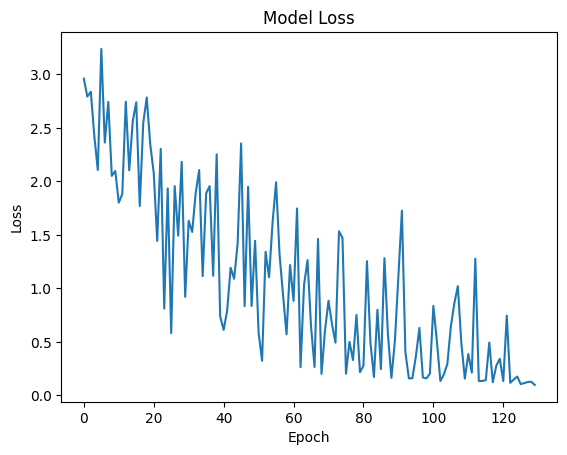

In [91]:
# Plot the loss curve
plt.plot(H.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()